- 음수값은 싹 날린다.
- 1. 음수값만 날린 상태로 테스트
- 2. 음수값 날리기 + num_~ 아웃라이어를 제거하고 테스트
    - 86400초 넘는거는 다 86400초로 바꿔
    - 무연님이 제시한 방법(각 유저가 자주 듣는 음악의 길이가 다를수 있지 않냐? )
    - 박지호가 제시한 방법(유니크 값의 비중)

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jiho_module as jm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

In [186]:
userlog_df = pd.read_parquet('D:/kkbox-churn-prediction-challenge/data/sample/sample_ratio_0.107/sample_user_logs.parquet/sample_user_logs (ratio=0.107).parquet')

In [187]:
train_df = pd.read_parquet('D:/kkbox-churn-prediction-challenge/data/sample/sample_ratio_0.107/sample_train.parquet/sample_train (ratio=0.107).parquet')

In [188]:
userlog_df['date'] = pd.to_datetime(userlog_df['date'])

In [4]:
len(userlog_df)

29812117

In [35]:
cols = list(userlog_df.columns)[1:8]
cols

['date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq']

- 유저 로그 데이터 중 재생한 곡의 수는 특정 구간에 모여있지만 아웃라이어가 큰 경우도 발생

<AxesSubplot: >

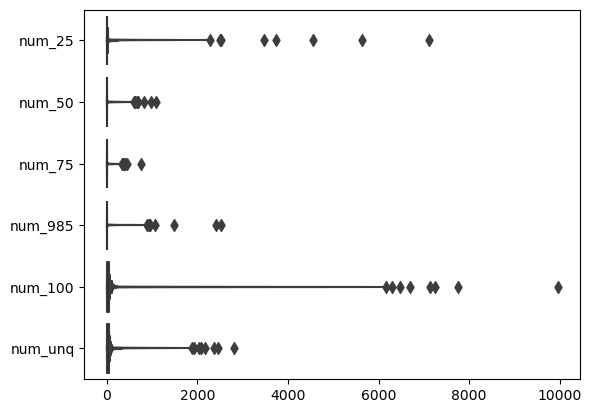

In [36]:
sns.boxenplot(data=userlog_df[cols] ,orient='h')

<AxesSubplot: >

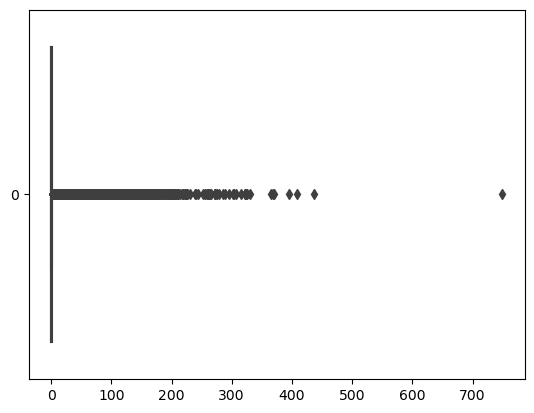

In [ ]:
sns.boxplot(data=userlog_df['num_75'] ,orient='h')

- 일반적인 유저의 데이터를 사용하여 total_secs의 이상치를 추정하기 위해서 1~3분위수 사이의 데이터만 필터링하기로 결정

In [25]:
round(userlog_df.describe(),2)

,msno_num,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,29812117.00,29812117.00,29812117.00,29812117.00,29812117.00,29812117.00,29812117.00,2.981212e+07
mean,3680168.65,6.56,1.63,1.02,1.13,30.72,30.24,-1.242483e+12
std,2123276.03,13.98,4.22,2.14,2.83,41.13,33.53,1.071502e+14
min,22.00,0.00,0.00,0.00,0.00,0.00,1.00,-9.223372e+15
25%,1849810.00,0.00,0.00,0.00,0.00,7.00,8.00,1.970850e+03
50%,3680100.00,2.00,1.00,0.00,0.00,17.00,19.00,4.690530e+03
75%,5507267.00,7.00,2.00,1.00,1.00,38.00,40.00,1.024499e+04
max,7376739.00,7104.00,1088.00,749.00,2516.00,9958.00,2798.00,9.223372e+15


### 음수 total_secs 필터링

In [189]:
def remove_negative(df):
    df = df[(df['total_secs'] >= 0)&
            (df['num_25'] >= 0)&
            (df['num_50'] >= 0)&
            (df['num_75'] >= 0)&
            (df['num_985'] >= 0)&
            (df['num_100'] >= 0)&
            (df['num_unq'] >= 0)]

    return df

### 86400 이상 total_secs 필터링

In [190]:
def remove_over_day(df):
   df = df[df['total_secs'] <= 86400]

   return df

### IQR의 배수에 따라 값을 필터링

In [191]:
def remove_quantile(df):
    for col in ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq']:
        level_1q = df[col].quantile(0.25)
        level_3q = df[col].quantile(0.75)
        IQR = level_3q - level_1q
        rev_range = 3
        df = df[(df[col] <= level_3q+(rev_range*IQR)) & (df[col] >= level_1q-(rev_range*IQR))]
    
    return df

### 표준편차의 2배수에 따라 값을 필터링

In [192]:
def remove_std(df):
    for col in ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq']:
        std = df[col].std()
        range_95 = std * 2
        mean = df[col].mean()
        df = df[(df[col] <= mean+range_95) & (df[col] >= mean-range_95)]
    
    return df

In [193]:
def calculate_percentages_of_unique(df):
    import pandas as pd
    import numpy as np
    cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100']
    total = df.loc[:, cols].sum(axis=1)
    new_col = 'unique_per_total_play'
    df[new_col] = total.div(df['num_unq'], axis=0)

    return df

In [194]:
def calculate_percentages_of_play_length(df):
    import pandas as pd
    import numpy as np
    cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100']
    num_25_75 = df.loc[:, cols[1:3]].sum(axis=1)
    num_75_100 = df.loc[:, cols[3:]].sum(axis=1)
    total = df.loc[:, cols].sum(axis=1)
    df['per_25'] = df['num_25'].div(total, axis=0)
    df['per_25_75'] = num_25_75.div(total, axis=0)
    df['per_100'] = num_75_100.div(total, axis=0)

    return df

In [196]:
df_new = remove_negative(userlog_df)
df_new = remove_over_day(df_new)
df_new = remove_std(df_new)
df_new = df_new.sort_values('msno_num')

In [198]:
df_new = calculate_percentages_of_play_length(df_new)
df_new = calculate_percentages_of_unique(df_new)

In [199]:
df_new

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,per_25,per_25_75,per_100,unique_per_total_play
17834832,22,2016-05-09,18,4,1,0,28,38,7472.530,0.352941,0.098039,0.549020,1.342105
17834849,22,2016-03-19,5,1,2,4,19,8,5365.042,0.161290,0.096774,0.741935,3.875000
17834848,22,2017-01-13,10,1,2,1,43,12,11074.387,0.175439,0.052632,0.771930,4.750000
17834847,22,2016-11-18,1,1,0,1,1,3,511.298,0.250000,0.250000,0.500000,1.333333
17834846,22,2016-09-23,4,2,0,2,6,8,1954.013,0.285714,0.142857,0.571429,1.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20657940,7376739,2015-02-24,4,6,0,2,13,19,5444.189,0.160000,0.240000,0.600000,1.315789
20657939,7376739,2015-05-16,1,0,0,1,18,17,4090.915,0.050000,0.000000,0.950000,1.176471
20657938,7376739,2015-02-23,0,1,2,0,14,15,4726.244,0.000000,0.176471,0.823529,1.133333
20657945,7376739,2015-05-20,3,0,1,0,28,15,7081.718,0.093750,0.031250,0.875000,2.133333


In [41]:
df_new.columns

Index(['msno_num', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
       'num_unq', 'total_secs', 'per_25', 'per_25_75', 'per_100',
       'unique_per_total_play'],
      dtype='object')

In [200]:
df_new_grouped = df_new.groupby('msno_num').agg({'date':'count',
                                                 'num_25':['mean', 'sum'], 
                                                 'num_50':['mean', 'sum'], 
                                                 'num_75':['mean', 'sum'], 
                                                 'num_985':['mean', 'sum'], 
                                                 'num_100':['mean', 'sum'],
                                                 'num_unq':['mean', 'sum'], 
                                                 'total_secs':['mean', 'sum'], 
                                                 'per_25':'mean', 
                                                 'per_25_75':'mean', 
                                                 'per_100':'mean',
                                                 'unique_per_total_play':'mean'})

In [201]:
df_new_grouped_train = train_df.join(df_new_grouped, on='msno_num', how='inner')

C:\Users\jiho\AppData\Local\Temp\ipykernel_20716\2585466581.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_new_grouped_train = train_df.join(df_new_grouped, on='msno_num', how='inner')


In [202]:
df_new_grouped_train = df_new_grouped_train.sort_values('msno_num')

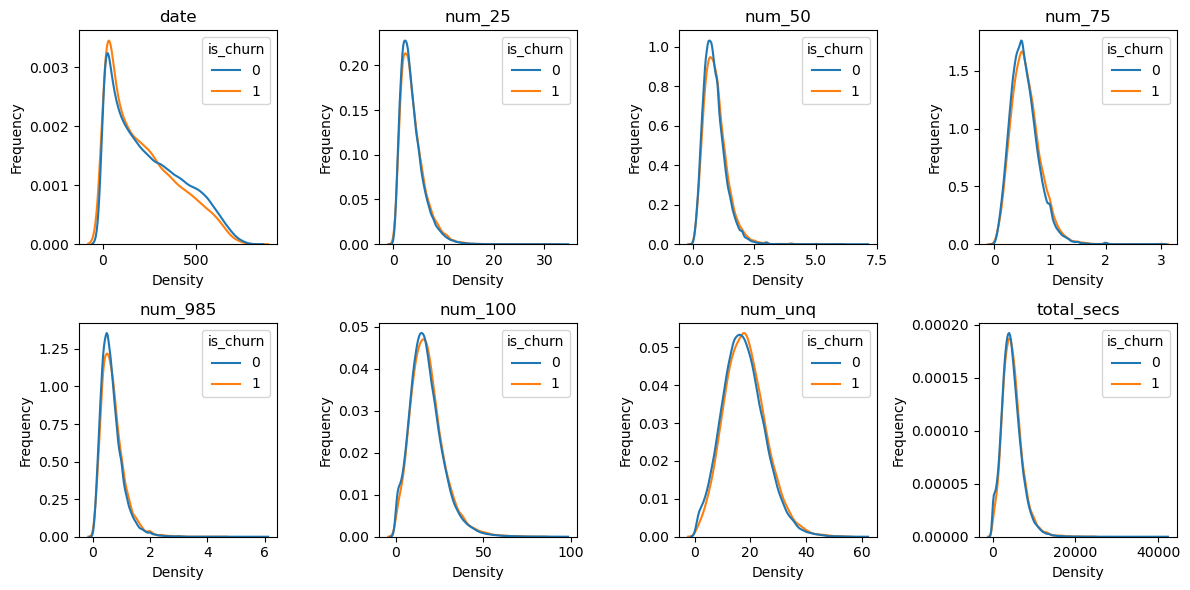

In [74]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for idx, col in enumerate(['date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']):
    ax = axs.flatten()[idx]
    jm.compare_density(df_new_grouped_train[df_new_grouped_train[col] != 0], col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Density')
    ax.set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [302]:
df_new_grouped_train.columns

Index([                       'msno_num',                        'is_churn',
                       ('date', 'count'),                ('num_25', 'mean'),
                       ('num_25', 'sum'),                ('num_50', 'mean'),
                       ('num_50', 'sum'),                ('num_75', 'mean'),
                       ('num_75', 'sum'),               ('num_985', 'mean'),
                      ('num_985', 'sum'),               ('num_100', 'mean'),
                      ('num_100', 'sum'),               ('num_unq', 'mean'),
                      ('num_unq', 'sum'),            ('total_secs', 'mean'),
                   ('total_secs', 'sum'),                ('per_25', 'mean'),
                   ('per_25_75', 'mean'),               ('per_100', 'mean'),
       ('unique_per_total_play', 'mean'),           'time_since_last_login',
                            'user_satis',           'satisfaction_category',
                            'seven_days',                          '15days',

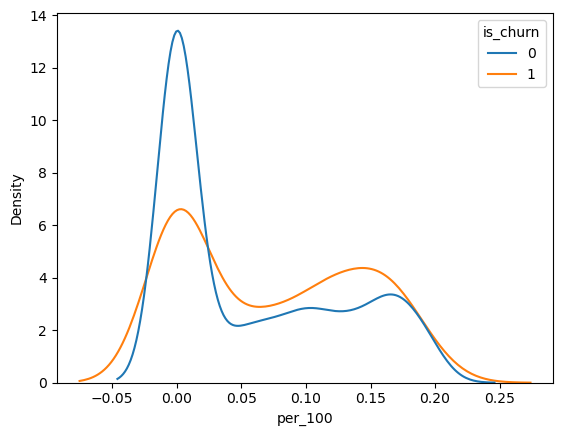

In [86]:
jm.compare_density(df_new_grouped_train[df_new_grouped_train['per_100'] < 0.2], 'per_100')

## 유저 사용량 변화

- 로그상 유저의 서비스 첫 사용 시의 사용 시간과 유저의 마지막 서비스 이용 시의 사용 시간의 비율
- 2 * (마지막 재생 시간 - 첫 재생 시간) / (마지막 재생 시간 + 첫 재생 시간)

In [211]:
user_metric = []
for user in df_new['msno_num'].sort_values().unique():
    user_data = df_new[df_new['msno_num'] == user].sort_values('date').reset_index(drop=True)
    if len(user_data) > 1:
        first_play_time = user_data['total_secs'].iloc[1]
        last_play_time = user_data['total_secs'].iloc[-1]
        metric = 2 * (last_play_time - first_play_time) / (last_play_time+first_play_time)
        user_metric.append(metric)
    else:
        user_metric.append(0)

In [214]:
df_new_grouped_train['user_satis'] = user_metric
df_new_grouped_train

,msno_num,is_churn,"(date, count)","(num_25, mean)","(num_25, sum)","(num_50, mean)","(num_50, sum)","(num_75, mean)","(num_75, sum)","(num_985, mean)",...,"(num_unq, mean)","(num_unq, sum)","(total_secs, mean)","(total_secs, sum)","(per_25, mean)","(per_25_75, mean)","(per_100, mean)","(unique_per_total_play, mean)",time_since_last_login,user_satis
0,22,0,276,3.456522,954,1.112319,307,0.702899,194,1.050725,...,9.199275,2539,3856.066239,1064274.282,0.175059,0.105194,0.719748,3.111390,7,-1.480416
1,56,0,189,6.185185,1169,1.047619,198,0.513228,97,0.582011,...,14.698413,2778,3821.650783,722291.998,0.233706,0.068279,0.698014,1.592490,35,-1.516360
2,201,1,46,0.804348,37,0.304348,14,0.108696,5,0.152174,...,16.434783,756,4834.399000,222382.354,0.042179,0.040157,0.917664,2.100995,26,1.236962
3,239,0,413,5.634383,2327,0.711864,294,0.527845,218,0.648910,...,17.530266,7240,3860.350998,1594324.962,0.226959,0.055824,0.717217,1.272243,43,0.399958
4,508,0,555,5.650450,3136,1.221622,678,0.859459,477,0.933333,...,17.515315,9721,4835.202978,2683537.653,0.214790,0.092367,0.692843,1.737720,4,1.789192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102699,7376493,0,370,11.764865,4353,1.240541,459,0.629730,233,0.686486,...,27.605405,10214,4740.150116,1753855.543,0.376818,0.076441,0.546741,1.142354,11,0.967955
102700,7376557,0,31,4.612903,143,0.225806,7,0.129032,4,0.354839,...,12.064516,374,2402.338258,74472.486,0.263167,0.029925,0.706909,1.192153,12,-0.823798
102701,7376578,0,27,3.370370,91,1.296296,35,0.703704,19,0.629630,...,21.666667,585,5107.371407,137899.028,0.129519,0.096042,0.774439,1.217450,5,1.383964
102702,7376643,0,350,6.140000,2149,1.214286,425,0.785714,275,0.894286,...,27.705714,9697,8659.274849,3030746.197,0.153361,0.052659,0.793980,1.673038,42,-1.786805


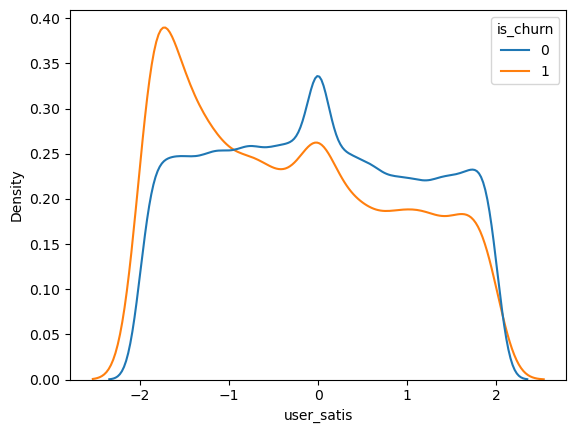

In [217]:
jm.compare_density(df_new_grouped_train, 'user_satis')

In [218]:
bin_edges = [-np.inf, -1.5, -0.5, 0.5, 1.5, np.inf]
bin_labels = ['Very Dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very Satisfied']

df_new_grouped_train['satisfaction_category'] = pd.cut(df_new_grouped_train['user_satis'], bins=bin_edges, labels=bin_labels)

df_new_grouped_train['satisfaction_category'] = pd.Categorical(df_new_grouped_train['satisfaction_category'], categories=bin_labels)

<AxesSubplot: xlabel='is_churn', ylabel='Count'>

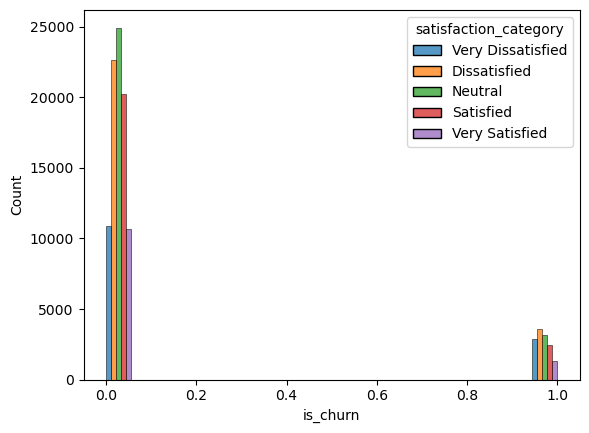

In [222]:
sns.histplot(df_new_grouped_train, x='is_churn', hue='satisfaction_category', multiple='dodge')

## 장기 미접속 유저
- 미접속 기간이 30일 이상인 유저

In [203]:
df_new_sorted = df_new.sort_values(['msno_num', 'date'])

df_new_sorted['time_since_last_login'] = df_new_sorted.groupby('msno_num')['date'].diff().fillna(pd.Timedelta(seconds=0))

max_non_login_duration = df_new_sorted.groupby('msno_num')['time_since_last_login'].max().reset_index()

In [205]:
max_non_login_duration

,msno_num,time_since_last_login
0,22,7 days
1,56,35 days
2,201,26 days
3,239,43 days
4,508,4 days
...,...,...
102699,7376493,11 days
102700,7376557,12 days
102701,7376578,5 days
102702,7376643,42 days


In [207]:
df_new_grouped_train = df_new_grouped_train.merge(max_non_login_duration, on='msno_num', how='inner')

In [208]:
df_new_grouped_train['time_since_last_login'] = df_new_grouped_train['time_since_last_login'].dt.days

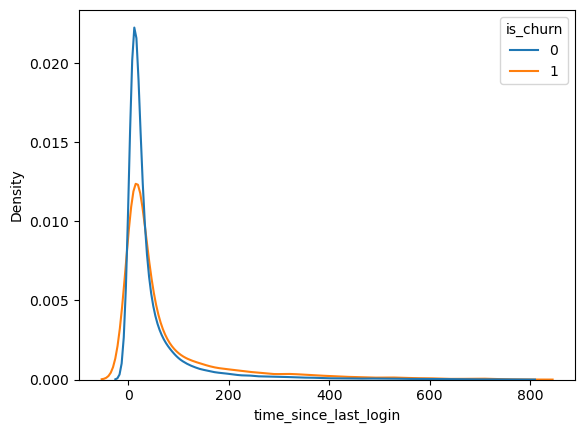

In [209]:
jm.compare_density(df_new_grouped_train, 'time_since_last_login')

In [224]:
df_new_grouped_train['seven_days'] = df_new_grouped_train['time_since_last_login'].apply(lambda x: 1 if x >= 7 else 0)
df_new_grouped_train['15days'] = df_new_grouped_train['time_since_last_login'].apply(lambda x: 1 if x >= 15 else 0)
df_new_grouped_train['a_month'] = df_new_grouped_train['time_since_last_login'].apply(lambda x: 1 if x >= 30 else 0)
df_new_grouped_train['90days'] = df_new_grouped_train['time_since_last_login'].apply(lambda x: 1 if x >= 90 else 0)
df_new_grouped_train

,msno_num,is_churn,"(date, count)","(num_25, mean)","(num_25, sum)","(num_50, mean)","(num_50, sum)","(num_75, mean)","(num_75, sum)","(num_985, mean)",...,"(per_25_75, mean)","(per_100, mean)","(unique_per_total_play, mean)",time_since_last_login,user_satis,satisfaction_category,seven_days,15days,a_month,90days
0,22,0,276,3.456522,954,1.112319,307,0.702899,194,1.050725,...,0.105194,0.719748,3.111390,7,-1.480416,Dissatisfied,1,0,0,0
1,56,0,189,6.185185,1169,1.047619,198,0.513228,97,0.582011,...,0.068279,0.698014,1.592490,35,-1.516360,Very Dissatisfied,1,1,1,0
2,201,1,46,0.804348,37,0.304348,14,0.108696,5,0.152174,...,0.040157,0.917664,2.100995,26,1.236962,Satisfied,1,1,0,0
3,239,0,413,5.634383,2327,0.711864,294,0.527845,218,0.648910,...,0.055824,0.717217,1.272243,43,0.399958,Neutral,1,1,1,0
4,508,0,555,5.650450,3136,1.221622,678,0.859459,477,0.933333,...,0.092367,0.692843,1.737720,4,1.789192,Very Satisfied,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102699,7376493,0,370,11.764865,4353,1.240541,459,0.629730,233,0.686486,...,0.076441,0.546741,1.142354,11,0.967955,Satisfied,1,0,0,0
102700,7376557,0,31,4.612903,143,0.225806,7,0.129032,4,0.354839,...,0.029925,0.706909,1.192153,12,-0.823798,Dissatisfied,1,0,0,0
102701,7376578,0,27,3.370370,91,1.296296,35,0.703704,19,0.629630,...,0.096042,0.774439,1.217450,5,1.383964,Satisfied,0,0,0,0
102702,7376643,0,350,6.140000,2149,1.214286,425,0.785714,275,0.894286,...,0.052659,0.793980,1.673038,42,-1.786805,Very Dissatisfied,1,1,1,0


In [229]:
df_new_grouped_train.columns[24:]

Index(['seven_days', '15days', 'a_month', '90days'], dtype='object')

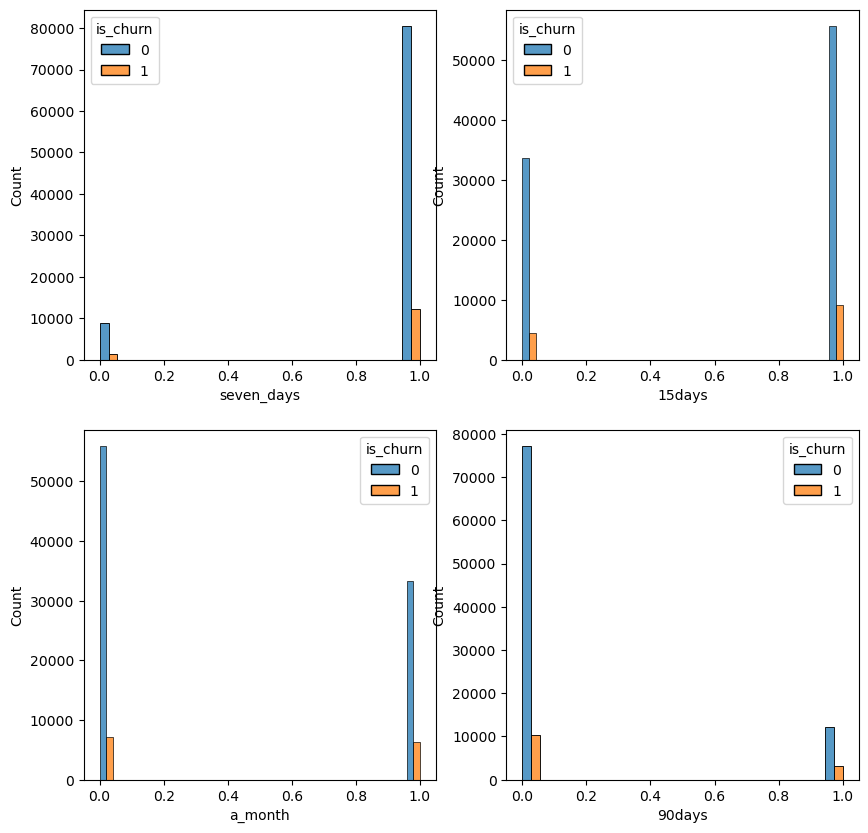

In [233]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
n_col = 2

for idx, name in enumerate(df_new_grouped_train.columns[24:]):
    sns.histplot(data=df_new_grouped_train, x=name, hue='is_churn', multiple="dodge", ax=axes[int(idx/n_col), int(idx%n_col)])


In [234]:
df_new_grouped_train.groupby(['a_month', 'is_churn']).count()

msno_num  (date, count)  (num_25, mean)  (num_25, sum)  \
a_month is_churn                                                           
0       0            55909          55909           55909          55909   
        1             7198           7198            7198           7198   
1       0            33365          33365           33365          33365   
        1             6232           6232            6232           6232   

                  (num_50, mean)  (num_50, sum)  (num_75, mean)  \
a_month is_churn                                                  
0       0                  55909          55909           55909   
        1                   7198           7198            7198   
1       0                  33365          33365           33365   
        1                   6232           6232            6232   

                  (num_75, sum)  (num_985, mean)  (num_985, sum)  ...  \
a_month is_churn                                                  ...   
0       0                 55909            55909           55909  ...   
        1                  7198             7198            7198  ...   
1       0                 33365            33365           33365  ...   
        1                  6232             6232            6232  ...   

                  (per_25, mean)  (per_25_75, mean)  (per_100, mean)  \
a_month is_churn                                                       
0       0                  55909              55909            55909   
        1                   7198               7198             7198   
1       0                  33365              33365            33365   
        1                   6232               6232             6232   

                  (unique_per_total_play, mean)  time_since_last_login  \
a_month is_churn                                                         
0       0                                 55909                  55909   
        1                                  7198                   7198   
1       0                                 33365                  33365   
        1                                  6232                   6232   

                  user_satis  satisfaction_category  seven_days  15days  \
a_month is_churn                                                          
0       0              55909                  55909       55909   55909   
        1               7198                   7198        7198    7198   
1       0              33365                  33365       33365   33365   
        1               6232                   6232        6232    6232   

                  90days  
a_month is_churn          
0       0          55909  
        1           7198  
1       0          33365  
        1           6232  

[4 rows x 26 columns]

In [235]:
33365/(55909+33365), 6232/(6232+7198)

(0.37373703429890004, 0.4640357408786299)

In [236]:
df_new_date_group = df_new.groupby('date')[['msno_num']].count()
df_new_date_group

,msno_num
date,
2015-01-01,17387
2015-01-02,17596
2015-01-03,17878
2015-01-04,18513
2015-01-05,18638
...,...
2017-03-27,41046
2017-03-28,41421
2017-03-29,41595


<AxesSubplot: xlabel='date'>

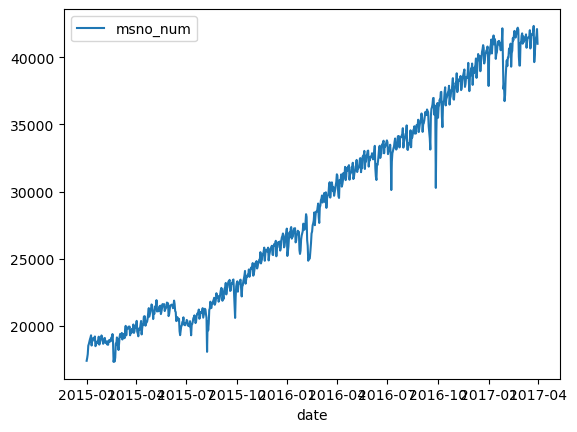

In [237]:
sns.lineplot(df_new_date_group)

In [238]:
df_new_date_group['diff'] = df_new_date_group.diff()

In [262]:
df_new_date_group[df_new_date_group['diff']<0].sort_values('diff')

,msno_num,diff
date,,
2016-09-27,30271,-5521.0
2017-03-25,39644,-2697.0
2016-07-08,30112,-2598.0
2015-08-08,18054,-2543.0
2017-01-28,37634,-2436.0
...,...,...
2015-07-05,20010,-4.0
2017-03-08,41314,-3.0
2015-05-11,21098,-2.0


In [242]:
hazard = df_new[df_new['date'] == pd.to_datetime('2016-09-27')].msno_num.unique()

In [250]:
df_new_grouped_train['hazard'] = np.where(df_new_grouped_train['msno_num'].isin(hazard), 1, 0)

<AxesSubplot: xlabel='hazard', ylabel='Count'>

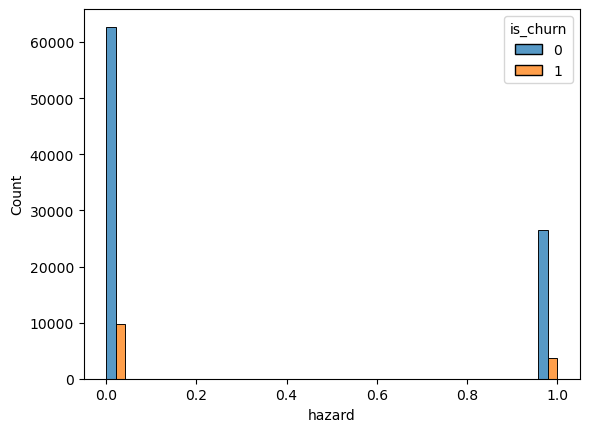

In [252]:
sns.histplot(data=df_new_grouped_train, x='hazard', hue='is_churn', multiple="dodge")

In [255]:
firsthazard = df_new[(df_new['date'] == pd.to_datetime('2016-09-27'))].msno_num.unique()
secondhazard = df_new[(df_new['date'] == pd.to_datetime('2017-01-28'))].msno_num.unique()
thirdhazard = df_new[(df_new['date'] == pd.to_datetime('2017-03-25'))].msno_num.unique()

In [263]:
hazard3times = set(firsthazard).intersection(secondhazard).intersection(thirdhazard)

In [264]:
df_new_grouped_train['hazard3times'] = np.where(df_new_grouped_train['msno_num'].isin(hazard3times), 1, 0)

<AxesSubplot: xlabel='hazard3times', ylabel='Count'>

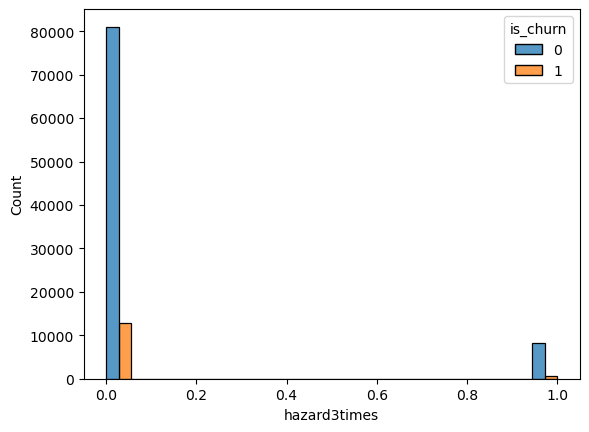

In [266]:
sns.histplot(data=df_new_grouped_train, x='hazard3times', hue='is_churn', multiple="dodge")

In [92]:
df_new_grouped_train[df_new_grouped_train['per_100'] < 0.2].groupby('is_churn').count()

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,per_25,per_25_75,per_100,unique_per_total_play
is_churn,,,,,,,,,,,,,
0,1811,1811,1811,1811,1811,1811,1811,1811,1811,1811,1811,1811,1811
1,153,153,153,153,153,153,153,153,153,153,153,153,153


In [276]:
df_new_grouped_train.columns

Index([                       'msno_num',                        'is_churn',
                       ('date', 'count'),                ('num_25', 'mean'),
                       ('num_25', 'sum'),                ('num_50', 'mean'),
                       ('num_50', 'sum'),                ('num_75', 'mean'),
                       ('num_75', 'sum'),               ('num_985', 'mean'),
                      ('num_985', 'sum'),               ('num_100', 'mean'),
                      ('num_100', 'sum'),               ('num_unq', 'mean'),
                      ('num_unq', 'sum'),            ('total_secs', 'mean'),
                   ('total_secs', 'sum'),                ('per_25', 'mean'),
                   ('per_25_75', 'mean'),               ('per_100', 'mean'),
       ('unique_per_total_play', 'mean'),           'time_since_last_login',
                            'user_satis',           'satisfaction_category',
                            'seven_days',                          '15days',

In [280]:
df_new_grouped_train[df_new_grouped_train.iloc[:,17] >= 0.25]

,msno_num,is_churn,"(date, count)","(num_25, mean)","(num_25, sum)","(num_50, mean)","(num_50, sum)","(num_75, mean)","(num_75, sum)","(num_985, mean)",...,"(unique_per_total_play, mean)",time_since_last_login,user_satis,satisfaction_category,seven_days,15days,a_month,90days,hazard,hazard3times
7,1219,0,44,5.840909,257,1.090909,48,0.454545,20,0.363636,...,1.579451,36,-1.217216,Dissatisfied,1,1,1,0,0,0
10,1335,0,392,7.323980,2871,1.392857,546,0.752551,295,0.670918,...,1.236706,26,0.190204,Neutral,1,1,0,0,0,0
12,1377,1,14,5.357143,75,1.642857,23,1.142857,16,1.357143,...,1.557734,29,0.920993,Satisfied,1,1,0,0,0,0
13,1383,0,3,11.666667,35,1.666667,5,1.333333,4,0.000000,...,1.235897,11,-0.016006,Neutral,1,0,0,0,0,0
14,1441,0,279,8.293907,2314,0.913978,255,0.541219,151,0.666667,...,1.247110,15,1.986120,Very Satisfied,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102687,7375799,0,432,6.789352,2933,1.185185,512,0.620370,268,0.571759,...,1.133827,13,1.136484,Satisfied,1,0,0,0,0,0
102694,7376132,0,71,10.535211,748,2.760563,196,1.197183,85,1.028169,...,1.102194,206,-0.153463,Neutral,1,1,1,1,0,0
102695,7376157,0,16,5.375000,86,1.250000,20,0.562500,9,0.375000,...,1.103095,14,-1.173284,Dissatisfied,1,0,0,0,0,0
102699,7376493,0,370,11.764865,4353,1.240541,459,0.629730,233,0.686486,...,1.142354,11,0.967955,Satisfied,1,0,0,0,1,1


In [286]:
df_new_grouped_train['15percent'] = np.where(df_new_grouped_train.iloc[:,17] >= 0.15, 1, 0)

In [289]:
df_new_grouped_train.columns

Index([                       'msno_num',                        'is_churn',
                       ('date', 'count'),                ('num_25', 'mean'),
                       ('num_25', 'sum'),                ('num_50', 'mean'),
                       ('num_50', 'sum'),                ('num_75', 'mean'),
                       ('num_75', 'sum'),               ('num_985', 'mean'),
                      ('num_985', 'sum'),               ('num_100', 'mean'),
                      ('num_100', 'sum'),               ('num_unq', 'mean'),
                      ('num_unq', 'sum'),            ('total_secs', 'mean'),
                   ('total_secs', 'sum'),                ('per_25', 'mean'),
                   ('per_25_75', 'mean'),               ('per_100', 'mean'),
       ('unique_per_total_play', 'mean'),           'time_since_last_login',
                            'user_satis',           'satisfaction_category',
                            'seven_days',                          '15days',

In [300]:
df_new_grouped_train['stranger'] = np.where(df_new_grouped_train.iloc[:,20] <= 1.5, 1, 0)

<AxesSubplot: xlabel='stranger', ylabel='Count'>

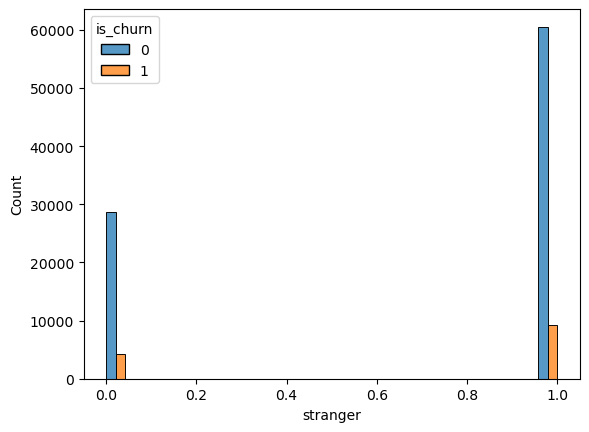

In [301]:
sns.histplot(data=df_new_grouped_train, x='stranger', hue='is_churn', multiple="dodge")

In [304]:
df_new_grouped_train.columns

Index([                       'msno_num',                        'is_churn',
                       ('date', 'count'),                ('num_25', 'mean'),
                       ('num_25', 'sum'),                ('num_50', 'mean'),
                       ('num_50', 'sum'),                ('num_75', 'mean'),
                       ('num_75', 'sum'),               ('num_985', 'mean'),
                      ('num_985', 'sum'),               ('num_100', 'mean'),
                      ('num_100', 'sum'),               ('num_unq', 'mean'),
                      ('num_unq', 'sum'),            ('total_secs', 'mean'),
                   ('total_secs', 'sum'),                ('per_25', 'mean'),
                   ('per_25_75', 'mean'),               ('per_100', 'mean'),
       ('unique_per_total_play', 'mean'),           'time_since_last_login',
                            'user_satis',           'satisfaction_category',
                            'seven_days',                          '15days',

In [317]:
round(df_new_grouped_train.describe(), 2)

,msno_num,is_churn,"(date, count)","(num_25, mean)","(num_25, sum)","(num_50, mean)","(num_50, sum)","(num_75, mean)","(num_75, sum)","(num_985, mean)",...,seven_days,15days,a_month,90days,hazard,hazard3times,25percent,10percent,15percent,stranger
count,102704.00,102704.00,102704.00,102704.00,102704.00,102704.00,102704.00,102704.00,102704.00,102704.00,...,102704.0,102704.00,102704.00,102704.00,102704.00,102704.00,102704.00,102704.00,102704.00,102704.00
mean,3683352.11,0.13,230.61,3.63,859.69,0.85,199.91,0.53,128.97,0.61,...,0.9,0.63,0.39,0.15,0.29,0.09,0.22,0.81,0.58,0.68
std,2127367.57,0.34,183.23,2.26,925.02,0.45,196.52,0.26,125.97,0.36,...,0.3,0.48,0.49,0.35,0.46,0.28,0.42,0.39,0.49,0.47
min,22.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1846435.50,0.00,69.00,2.04,176.00,0.54,46.00,0.35,29.00,0.37,...,1.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
50%,3684494.00,0.00,192.00,3.14,542.00,0.78,137.00,0.50,89.00,0.56,...,1.0,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
75%,5520661.50,0.00,364.00,4.70,1238.00,1.08,297.00,0.67,194.00,0.79,...,1.0,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00
max,7376739.00,1.00,801.00,34.00,8635.00,7.00,1364.00,3.00,854.00,5.00,...,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [270]:
round(df_new.describe(),2)

,msno_num,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,per_25,per_25_75,per_100,unique_per_total_play
count,23684086.00,23684086.00,23684086.00,23684086.00,23684086.00,23684086.00,23684086.00,23684086.00,23684086.00,23684086.00,23684086.00,23684086.00
mean,3681974.03,3.73,0.87,0.56,0.66,18.38,18.22,4883.96,0.17,0.08,0.76,1.68
std,2124453.07,5.32,1.29,0.82,1.01,17.68,14.62,4520.10,0.20,0.13,0.24,3.10
min,22.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
25%,1848409.00,0.00,0.00,0.00,0.00,5.00,6.00,1556.95,0.00,0.00,0.63,1.00
50%,3681476.00,2.00,0.00,0.00,0.00,13.00,14.00,3526.08,0.10,0.04,0.82,1.09
75%,5512390.00,5.00,1.00,1.00,1.00,26.00,27.00,6886.79,0.25,0.10,0.95,1.39
max,7376739.00,34.00,7.00,3.00,5.00,103.00,61.00,86360.55,1.00,1.00,1.00,111.00


<AxesSubplot: xlabel='per_100', ylabel='Density'>

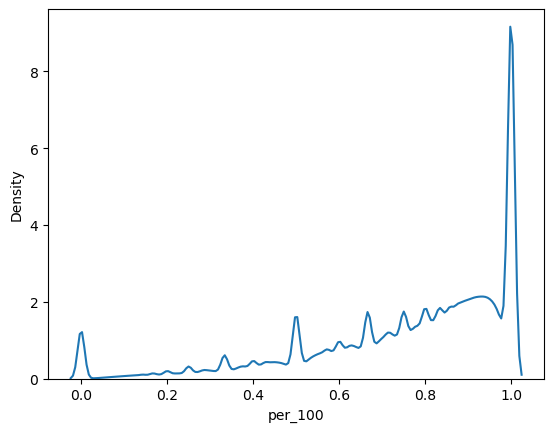

In [35]:
sns.kdeplot(df_new['per_100'])

<AxesSubplot: xlabel='per_25', ylabel='Density'>

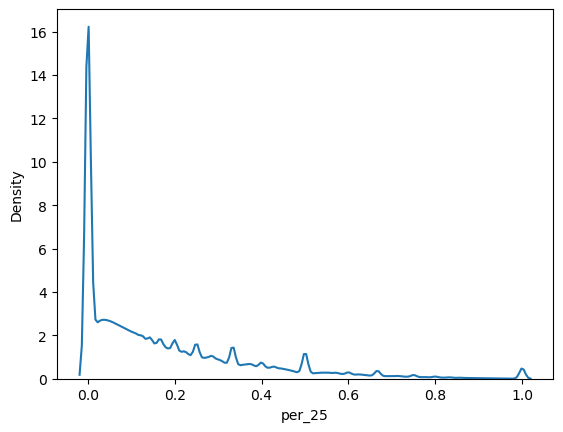

In [25]:
sns.kdeplot(userlog_df['per_25'])

In [16]:
calculate_percentages_of_unique(userlog_df)

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,unique_per_total_play
0,3609,2015-02-19,0,1,0,0,21,22,5263.376,1.000000
1,3609,2015-05-06,4,0,0,0,19,20,4745.286,0.869565
2,3609,2015-07-12,12,5,2,2,11,31,4389.907,0.968750
3,3609,2015-09-08,1,0,0,0,4,5,978.743,1.000000
4,3609,2015-11-15,0,0,0,0,27,25,6322.493,0.925926
...,...,...,...,...,...,...,...,...,...,...
29812112,7374450,2017-03-01,1,0,0,0,4,1,1030.690,0.200000
29812113,7374450,2017-03-02,0,1,1,0,7,2,2001.529,0.222222
29812114,7374450,2017-03-15,0,1,1,0,13,2,3402.203,0.133333
29812115,7374450,2017-03-10,0,0,0,1,2,2,684.929,0.666667


<AxesSubplot: xlabel='unique_per_total_play', ylabel='Density'>

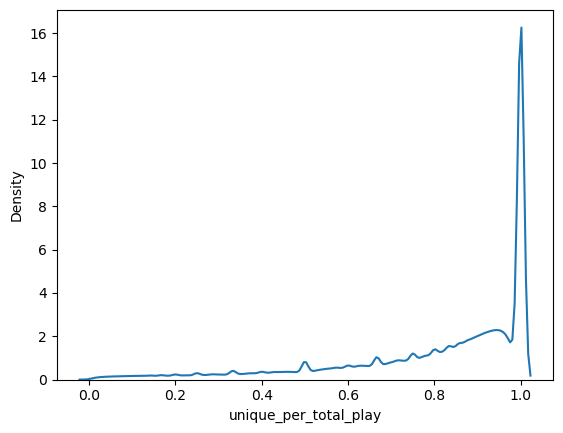

In [17]:
sns.kdeplot(userlog_df['unique_per_total_play'])

In [4]:
def calculate_percentages_of_unique(df):
    import pandas as pd
    import numpy as np
    df_func = df.copy()
    cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100']
    total = df_func.loc[:, cols].sum(axis=1)
    unq_cols = [col + '_unq_number' for col in cols]
    new_cols = [col + "_unq_number_percent" for col in cols]
    df_func[unq_cols] = df_func[cols].div(total, axis=0).mul(df_func['num_unq'], axis=0)
    unq_total = df_func.loc[:, unq_cols].sum(axis=1)
    df_func[new_cols] = df_func[unq_cols].div(unq_total, axis=0)

    return df_func

In [95]:
calculate_percentages_of_unique(userlog_weired)

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,num_25_unq_number,num_50_unq_number,num_75_unq_number,num_985_unq_number,num_100_unq_number,num_25_unq_number_percent,num_50_unq_number_percent,num_75_unq_number_percent,num_985_unq_number_percent,num_100_unq_number_percent
293255,215812,2017-01-14,1500,5,2,0,0,650,7632.235,646.980756,2.156603,0.862641,0.000000,0.000000,0.995355,0.003318,0.001327,0.000000,0.000000
3282286,619511,2015-11-25,1019,70,73,6,3,406,24357.560,353.299744,24.269855,25.309991,2.080273,1.040137,0.870196,0.059778,0.062340,0.005124,0.002562
3424103,1062933,2017-03-04,5639,2,1,0,202,38,54517.972,36.667009,0.013005,0.006502,0.000000,1.313484,0.964921,0.000342,0.000171,0.000000,0.034565
4827991,3210214,2015-11-01,1317,11,2,3,124,863,38001.618,780.076184,6.515443,1.184626,1.776939,73.446809,0.903912,0.007550,0.001373,0.002059,0.085106
5266199,3157364,2015-07-03,1533,64,50,28,284,242,108097.042,189.375191,7.906075,6.176621,3.458908,35.083206,0.782542,0.032670,0.025523,0.014293,0.144972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27419427,1251643,2016-03-12,1201,58,11,4,1,1117,11940.820,1052.170196,50.812549,9.636863,3.504314,0.876078,0.941961,0.045490,0.008627,0.003137,0.000784
27419442,1251643,2016-03-27,1006,26,3,4,3,893,6454.741,862.147793,22.282150,2.571017,3.428023,2.571017,0.965451,0.024952,0.002879,0.003839,0.002879
27478252,4068556,2016-01-18,1465,139,104,68,2499,580,628432.117,198.760234,18.858480,14.109942,9.225731,339.045614,0.342690,0.032515,0.024327,0.015906,0.584561
27775613,3083419,2016-03-14,1076,273,73,10,15,1334,65250.384,991.972357,251.680719,67.299240,9.219074,13.828611,0.743607,0.188666,0.050449,0.006911,0.010366


In [98]:
userlog_df['num_25'].sum(), userlog_df['num_50'].sum(), userlog_df['num_75'].sum(), userlog_df['num_985'].sum(), userlog_df['num_100'].sum()

(195530125, 48641390, 30377530, 33761645, 915857142)

(0.0, 7000.0)

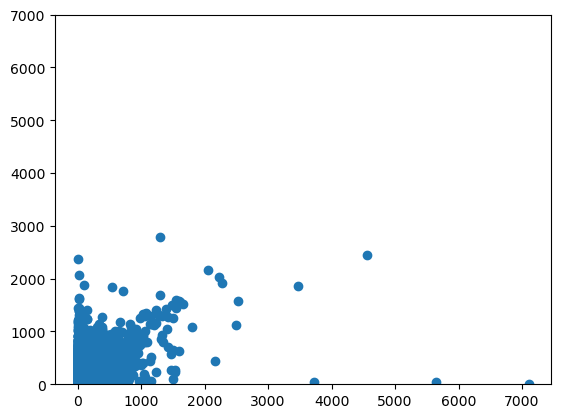

In [49]:
plt.scatter(userlog_df['num_25'], userlog_df['num_unq'])
plt.ylim(0,7000)

In [42]:
userlog_df[userlog_df['num_unq'] > 1000].head(50)

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1120072,4372511,2016-01-20,389,654,117,9,4,1050,70578.880
1120089,4372511,2016-09-04,384,405,322,11,0,1088,80506.564
1592342,6136845,2015-09-05,150,35,29,27,4748,1227,1078038.944
1592396,6136845,2015-09-13,149,36,30,27,4747,1235,1077441.433
2653877,7082529,2016-02-02,61,17,18,31,3882,1116,905236.074
2653958,7082529,2016-09-11,102,35,32,28,6118,1871,1381357.927
2653996,7082529,2017-02-17,68,37,29,25,5983,1395,1371960.122
3506693,4851574,2015-12-02,14,8,2,4,2212,1380,570627.471
3506755,4851574,2016-09-14,7,3,2,16,1559,1196,407719.517
3506837,4851574,2015-06-25,9,5,3,2,1804,1156,470139.430


In [40]:
userlog_df[(userlog_df['msno_num'] == 4068556) & (userlog_df['total_secs'] > 86400)]

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
27477720,4068556,2015-10-06,352,31,24,16,471,401,123866.983
27477775,4068556,2015-08-16,352,51,27,17,541,492,137118.154
27477853,4068556,2015-06-21,83,8,5,1,848,141,230715.904
27477971,4068556,2015-09-02,396,32,20,17,306,357,99353.347
27478025,4068556,2015-07-06,80,3,5,1,411,173,110351.280
27478068,4068556,2015-09-10,224,25,19,9,338,372,88865.831
27478222,4068556,2015-09-22,408,33,14,17,365,382,97405.097
27478235,4068556,2015-07-26,188,18,12,17,567,367,139167.010
27478252,4068556,2016-01-18,1465,139,104,68,2499,580,628432.117


In [4]:
userlog_filter1 = (userlog_df['total_secs'] <= 86400)
userlog_filter2 = (userlog_df['total_secs'] > 0)
userlog_filter3 = ((userlog_df['num_100'] >= 7) &
                   (userlog_df['num_100'] <= 38) &
                   (userlog_df['num_unq'] >= 1) &
                   (userlog_df['num_unq'] <= 40)
                )


In [6]:
userlog_filtered = userlog_df[userlog_filter1&userlog_filter2]

In [7]:
normal_userlog= userlog_df[userlog_filter1&userlog_filter2&userlog_filter3]

<AxesSubplot: xlabel='num_100', ylabel='total_secs'>

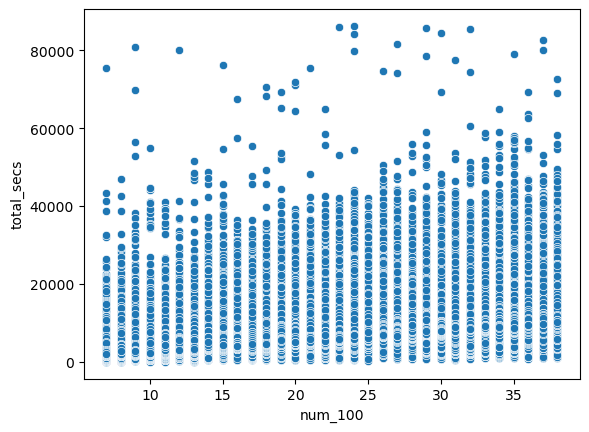

In [13]:
sns.scatterplot(data=normal_userlog, x='num_100', y='total_secs')

<AxesSubplot: xlabel='num_unq', ylabel='total_secs'>

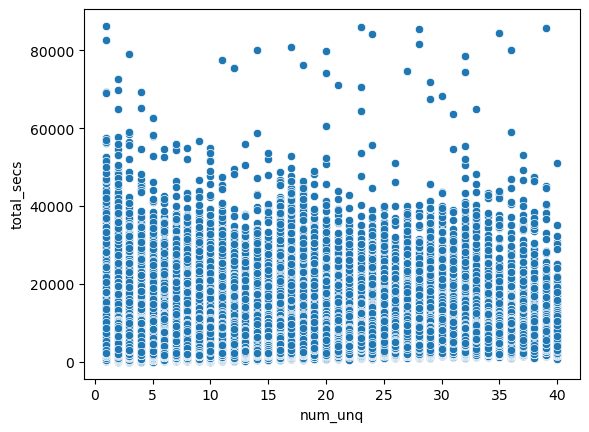

In [14]:
sns.scatterplot(data=normal_userlog, x='num_unq', y='total_secs')

<AxesSubplot: xlabel='num_25', ylabel='total_secs'>

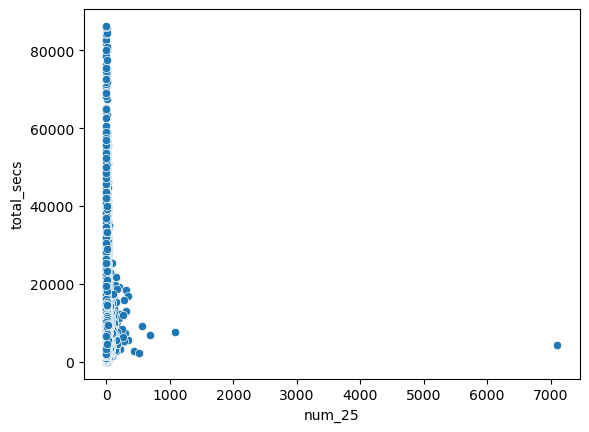

In [15]:
sns.scatterplot(data=normal_userlog, x='num_25', y='total_secs')

In [10]:
cols = list(normal_userlog.columns)[2:8]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(normal_userlog[cols], normal_userlog['total_secs'], test_size=0.2)

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [20]:
lin_reg.coef_

array([  7.7628796 ,  99.73342384, 172.05755143, 138.99005252,
       244.97770742,   1.73299321])

In [21]:
pred = lin_reg.predict(X_test)
lin_reg.score(X_test, y_test)

0.9020132679646989

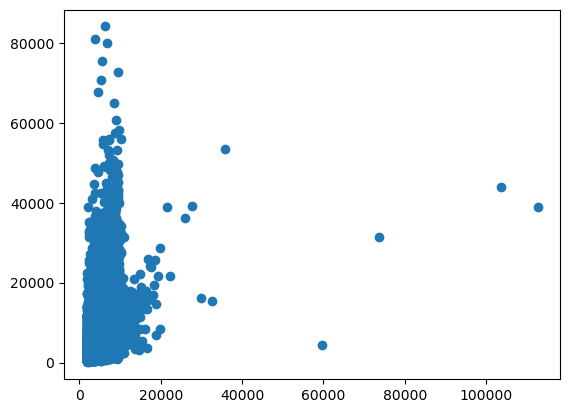

In [25]:
plt.scatter(pred, y_test)

In [27]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [29]:
xgb_pred = xgb_reg.predict(X_test)

In [32]:
mse = mean_squared_error(y_test, xgb_pred)
mse

484715.7215775076

In [9]:
userlog_filtered.describe()

,msno_num,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,2.979856e+07,2.979856e+07,2.979856e+07,2.979856e+07,2.979856e+07,2.979856e+07,2.979856e+07,2.979856e+07
mean,3.680191e+06,6.551767e+00,1.629344e+00,1.017443e+00,1.130863e+00,3.054995e+01,3.018438e+01,8.080970e+03
std,2.123262e+06,1.391772e+01,4.175537e+00,2.099151e+00,2.794401e+00,3.886469e+01,3.324219e+01,9.578759e+03
min,2.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-03
25%,1.849810e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,8.000000e+00,1.971000e+03
50%,3.680208e+06,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,1.900000e+01,4.689239e+03
75%,5.507267e+06,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.800000e+01,4.000000e+01,1.023747e+04
max,7.376739e+06,7.104000e+03,6.540000e+02,3.220000e+02,2.516000e+03,4.149000e+03,2.447000e+03,8.640000e+04


- 그러나 해당 조건에 모두 맞는 사람은 없었음...
- 유저의 사용 패턴이 제각각 너무 달라서 그런 것이라고 생각

In [ ]:
userlog_df[userlog_filter1&userlog_filter2&userlog_filter3&userlog_filter4]

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs


In [ ]:
userlog_df[]

In [ ]:
userlog_df[userlog_df['num_100'] > 480]

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
19235,1168863,2016-12-08,84,20,19,27,1532,158,409138.154
19324,1168863,2016-09-01,24,6,3,5,488,83,128319.363
21598,1380401,2015-07-18,6,2,2,5,610,211,145010.322
25958,1522029,2017-01-09,2,0,0,2,1764,519,394385.919
26057,1522029,2015-07-03,1,0,1,0,526,130,129401.869
...,...,...,...,...,...,...,...,...,...
29632474,6119484,2015-05-14,14,13,7,5,515,202,135680.189
29740334,4129278,2016-02-08,51,4,7,6,529,302,139760.441
29742945,4174818,2016-12-16,8,3,0,1,509,303,121890.902
29742979,4174818,2016-12-08,9,12,6,3,658,431,163876.021


<AxesSubplot: >

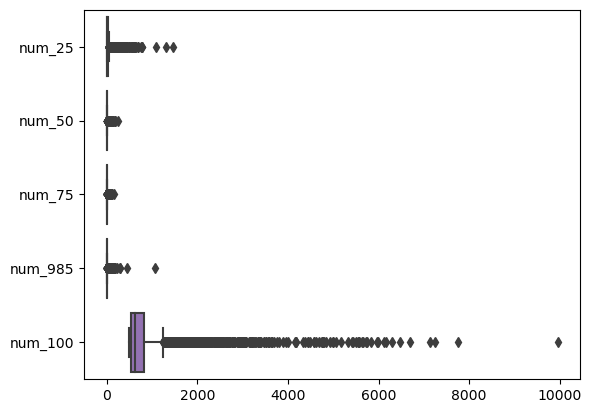

In [ ]:
sns.boxplot(data=userlog_df[userlog_df['num_100'] > 480][cols] ,orient='h')

<AxesSubplot: >

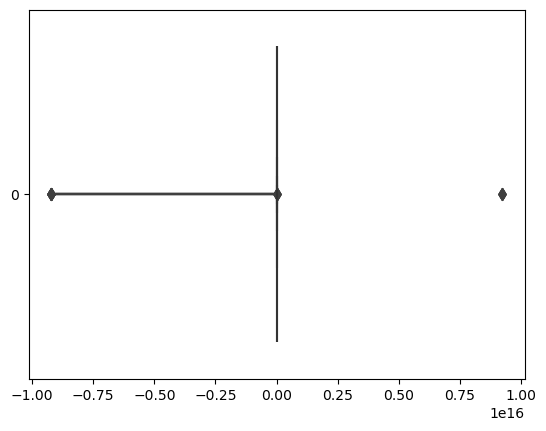

In [ ]:
sns.boxenplot(data=userlog_df['total_secs'] ,orient='h')

In [ ]:
userlog_df[userlog_df['total_secs'] < 0]

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
13794,697708,2015-07-17,13,1,4,4,74,40,-9.223372e+15
15320,796953,2015-07-12,6,0,0,0,105,104,-9.223372e+15
15327,796953,2015-07-14,2,0,0,1,15,16,-9.223372e+15
35466,1927276,2015-09-01,4,2,2,5,17,30,-9.223372e+15
35830,1927276,2015-08-07,1,2,1,4,52,57,-9.223372e+15
...,...,...,...,...,...,...,...,...,...
29748460,4392079,2015-09-30,2,0,0,0,51,52,-9.223372e+15
29790724,6460491,2015-06-28,4,0,1,0,45,47,-9.223372e+15
29791059,6460491,2015-06-01,1,0,0,1,18,19,-9.223372e+15
29791174,6460491,2015-06-09,4,1,3,0,46,51,-9.223372e+15


In [ ]:
userlog_filtered = userlog_df[userlog_filter1 & userlog_filter2]

- 선형적인 모습이 보이는지 확인하기 위해서 시각화를 진행했으나, 선형적인 데이터 분포는 아니었음

<AxesSubplot: ylabel='total_secs'>

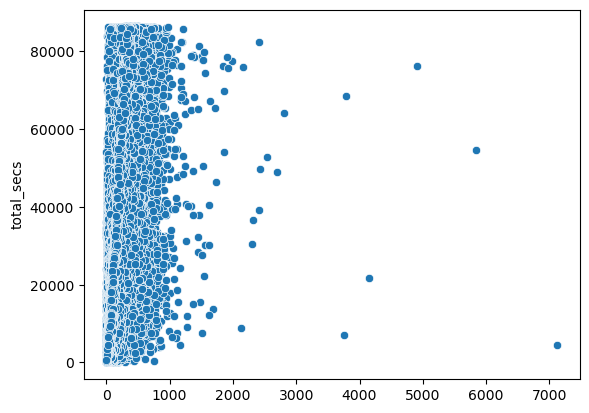

In [ ]:
sns.scatterplot(data=userlog_filtered, 
                x=(userlog_filtered['num_25']+userlog_filtered['num_50']+userlog_filtered['num_75']+userlog_filtered['num_985']+userlog_filtered['num_100']),
                y=userlog_filtered['total_secs'])

<AxesSubplot: xlabel='num_100', ylabel='total_secs'>

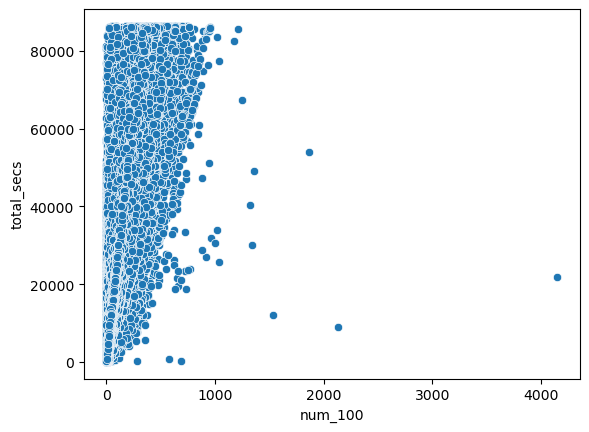

In [ ]:
sns.scatterplot(data=userlog_filtered, 
                x=userlog_filtered['num_100'],
                y=userlog_filtered['total_secs'])

In [ ]:
userlog_df[(userlog_df['msno_num'] == 1168863) & (userlog_df['total_secs'] > 86400)].sort_values('date')

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
19324,1168863,2016-09-01,24,6,3,5,488,83,128319.363
19235,1168863,2016-12-08,84,20,19,27,1532,158,409138.154


In [ ]:
userlog_df[(userlog_df['msno_num'] == 1168863) & (userlog_df['date'] >= '2016-12-08	')].sort_values('date')

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
19235,1168863,2016-12-08,84,20,19,27,1532,158,409138.154
19242,1168863,2016-12-09,8,3,3,4,58,51,16357.139
19249,1168863,2016-12-10,2,0,1,2,91,84,22154.288
19256,1168863,2016-12-11,1,1,0,0,30,30,7299.008
19263,1168863,2016-12-12,1,1,0,3,15,16,4718.683
...,...,...,...,...,...,...,...,...,...
19346,1168863,2017-03-27,9,2,1,4,40,40,10849.741
19350,1168863,2017-03-28,9,1,2,5,61,55,17333.113
19329,1168863,2017-03-29,4,2,0,2,72,50,18149.720
19338,1168863,2017-03-30,2,1,0,4,52,45,13763.908


- PCA TEST 1 극단치에 있는 유저 로그를 골라냄

In [ ]:
userlog_df.columns[2:9]

Index(['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs'],
      dtype='object')

In [ ]:
cols = userlog_df.columns[2:9]

In [ ]:
df_targ = userlog_df[cols]

In [ ]:
scaler = MinMaxScaler()
df_targ_scaled = scaler.fit_transform(df_targ)

In [ ]:
pca = PCA(n_components=2)
user_log_pca = pca.fit_transform(df_targ_scaled)

In [ ]:
df_user_log_pca=pd.DataFrame(user_log_pca, columns=['pca_x', 'pca_y'])

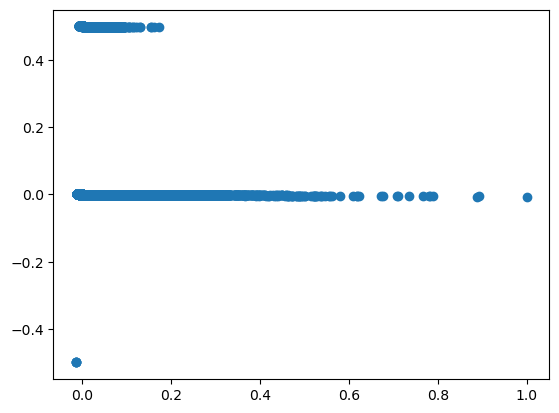

In [ ]:
plt.scatter(x=df_user_log_pca['pca_x'], y=df_user_log_pca['pca_y'])

In [ ]:
userlog_df['pca_x'] = df_user_log_pca['pca_x']
userlog_df['pca_y'] = df_user_log_pca['pca_y']

In [ ]:
userlog_df[userlog_df['pca_y'] > 0.2].index

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,cluster,pca_x,pca_y
13794,697708,2015-07-17,13,1,4,4,74,40,-9.223372e+15,4,0.008075,0.499887
15320,796953,2015-07-12,6,0,0,0,105,104,-9.223372e+15,4,0.029902,0.499747
15327,796953,2015-07-14,2,0,0,1,15,16,-9.223372e+15,4,-0.002339,0.499959
35466,1927276,2015-09-01,4,2,2,5,17,30,-9.223372e+15,4,0.003019,0.499924
35830,1927276,2015-08-07,1,2,1,4,52,57,-9.223372e+15,4,0.012920,0.499859
...,...,...,...,...,...,...,...,...,...,...,...,...
29748460,4392079,2015-09-30,2,0,0,0,51,52,-9.223372e+15,4,0.010805,0.499872
29790724,6460491,2015-06-28,4,0,1,0,45,47,-9.223372e+15,4,0.009098,0.499884
29791059,6460491,2015-06-01,1,0,0,1,18,19,-9.223372e+15,4,-0.001253,0.499951
29791174,6460491,2015-06-09,4,1,3,0,46,51,-9.223372e+15,4,0.010846,0.499873


In [ ]:
userlog_df[userlog_df['pca_y'] < -0.2]

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,cluster,pca_x,pca_y
4161943,6592924,2015-06-28,0,0,0,0,1,1,9.223372e+15,0,-0.014368,-0.499984
6207701,5678277,2015-08-13,0,0,0,0,1,1,9.223372e+15,0,-0.014368,-0.499984
24166098,5122385,2015-05-25,0,0,0,0,3,1,9.223372e+15,0,-0.014318,-0.499984
27438485,2199597,2015-05-04,0,0,0,0,1,1,9.223372e+15,0,-0.014368,-0.499984


- PCA TEST2. total_secs가 0~86400인 경우만 필터링하여 다시 PCA

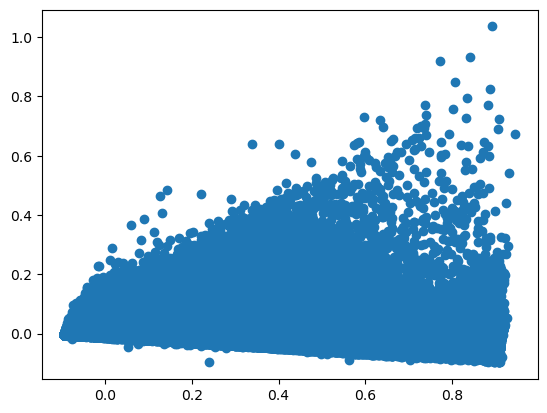

In [ ]:
userlog_filtered = userlog_df[userlog_filter1 & userlog_filter2]

userlog_filtered = userlog_filtered[cols]

userlog_filtered_scaled = scaler.fit_transform(userlog_filtered)


pca2 = PCA(n_components=2)
user_log_filtered_pca = pca2.fit_transform(userlog_filtered_scaled)

df_user_log_filtered_pca=pd.DataFrame(user_log_filtered_pca, columns=['pca_x', 'pca_y'])

plt.scatter(x=df_user_log_filtered_pca['pca_x'], y=df_user_log_filtered_pca['pca_y'])

In [ ]:
userlog_filtered['pca_y'] = df_user_log_filtered_pca['pca_y']

C:\Users\jiho\AppData\Local\Temp\ipykernel_21336\1175758428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userlog_filtered['pca_y'] = df_user_log_filtered_pca['pca_y']


In [ ]:
df_user_log_filtered_pca

,pca_x,pca_y
0,-0.032912,-0.001846
1,-0.038993,-0.002628
2,-0.042618,0.007989
3,-0.083122,-0.003400
4,-0.020534,-0.002801
...,...,...
29798554,-0.082686,-0.004581
29798555,-0.071387,-0.002949
29798556,-0.055193,-0.004277
29798557,-0.086654,-0.003963


In [ ]:
userlog_filtered['pca_x'] = df_user_log_filtered_pca['pca_x']
userlog_filtered['pca_y'] = df_user_log_filtered_pca['pca_y']

In [ ]:
df_user_log_filtered_pca

,pca_x,pca_y
0,-0.032912,-0.001846
1,-0.038993,-0.002628
2,-0.042618,0.007989
3,-0.083122,-0.003400
4,-0.020534,-0.002801
...,...,...
29798554,-0.082686,-0.004581
29798555,-0.071387,-0.002949
29798556,-0.055193,-0.004277
29798557,-0.086654,-0.003963


In [ ]:
params = {'n_clusters' : [2,3,4,5,6,7]}

grid_kmeans = GridSearchCV(KMeans(), param_grid=params, verbose=2)

grid_kmeans.fit(df_user_log_filtered_pca)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=2; total time=  55.1s


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=2; total time=  51.7s


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=2; total time=  51.3s


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=2; total time=  54.6s


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=2; total time=  49.6s


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=3; total time= 1.5min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=3; total time= 1.5min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=3; total time= 1.4min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=3; total time= 1.3min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=3; total time= 1.4min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=4; total time= 1.9min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=4; total time= 2.1min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=4; total time= 2.1min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=4; total time= 2.4min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=4; total time= 2.0min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=5; total time= 2.8min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=5; total time= 2.9min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=5; total time= 3.0min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=5; total time= 2.6min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=5; total time= 3.2min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=6; total time= 3.0min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=6; total time= 3.5min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=6; total time= 2.8min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=6; total time= 2.9min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=6; total time= 3.4min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=7; total time= 3.6min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=7; total time= 2.7min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=7; total time= 3.5min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=7; total time= 3.0min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END .......................................n_clusters=7; total time= 2.9min


c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


GridSearchCV(estimator=KMeans(), param_grid={'n_clusters': [2, 3, 4, 5, 6, 7]},
             verbose=2)

In [ ]:
best_kmeans = grid_kmeans.best_estimator_

In [ ]:
df_user_log_filtered_pca['cluster'] = best_kmeans.predict(df_user_log_filtered_pca)

<AxesSubplot: xlabel='pca_x', ylabel='pca_y'>

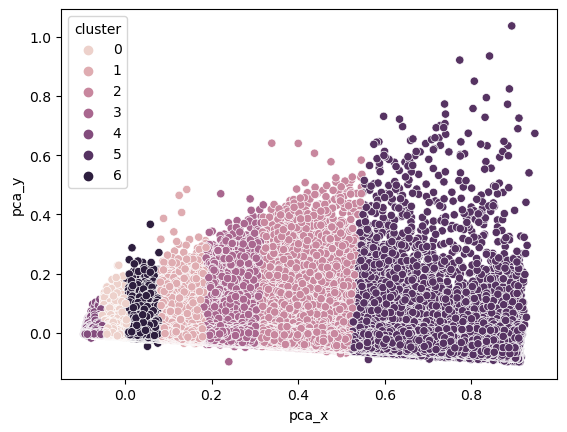

In [ ]:
sns.scatterplot(x=df_user_log_filtered_pca['pca_x'], y=df_user_log_filtered_pca['pca_y'], hue=df_user_log_filtered_pca['cluster'])

In [ ]:
import joblib

joblib.dump(grid_kmeans, 'grid_kmeans.joblib')

['grid_kmeans.joblib']

In [ ]:
userlog_filtered['cluster'] = df_user_log_filtered_pca['cluster']

In [ ]:
round(userlog_filtered[userlog_filtered['cluster'] == 0].describe(), 2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,pca_x,pca_y,cluster
count,7868476.00,7868476.00,7868476.00,7868476.00,7868476.00,7868476.00,7868476.00,7865198.00,7865198.00,7868476.0
mean,7.26,1.72,1.08,1.15,21.47,25.99,5892.10,-0.00,0.00,0.0
std,12.67,3.15,1.60,1.70,6.54,13.82,1357.48,0.11,0.01,0.0
min,0.00,0.00,0.00,0.00,0.00,1.00,2458.77,-0.09,-0.10,0.0
25%,1.00,0.00,0.00,0.00,17.00,18.00,4700.39,-0.07,-0.00,0.0
50%,3.00,1.00,1.00,1.00,21.00,24.00,5727.66,-0.04,-0.00,0.0
75%,9.00,2.00,2.00,2.00,26.00,31.00,7001.81,0.03,0.00,0.0
max,7104.00,91.00,47.00,186.00,359.00,773.00,8796.14,0.93,0.85,0.0


In [ ]:
round(userlog_filtered[userlog_filtered['cluster'] == 1].describe(), 2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,pca_x,pca_y,cluster
count,2334672.00,2334672.00,2334672.00,2334672.00,2334672.00,2334672.00,2334672.00,2333579.00,2333579.00,2334672.0
mean,12.30,3.13,1.98,2.23,70.88,65.48,18612.18,0.00,-0.00,1.0
std,21.33,6.62,3.21,3.68,14.03,28.92,2436.60,0.11,0.01,0.0
min,0.00,0.00,0.00,0.00,0.00,1.00,11940.82,-0.09,-0.10,1.0
25%,2.00,0.00,0.00,0.00,62.00,50.00,16468.13,-0.07,-0.00,1.0
50%,5.00,1.00,1.00,1.00,70.00,67.00,18306.39,-0.04,-0.00,1.0
75%,15.00,4.00,3.00,3.00,80.00,81.00,20602.96,0.03,0.00,1.0
max,1652.00,261.00,126.00,529.00,736.00,1514.00,23813.73,0.93,1.04,1.0


In [121]:
round(userlog_filtered[userlog_filtered['cluster'] == 2].describe(), 2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,pca_x,pca_y,cluster
count,740635.00,740635.00,740635.00,740635.00,740635.00,740635.00,740635.00,739856.00,739856.00,740635.0
mean,10.01,3.04,1.92,2.69,162.74,115.06,40673.48,0.00,-0.00,2.0
std,22.60,9.41,4.66,9.53,30.46,53.78,4645.85,0.12,0.01,0.0
min,0.00,0.00,0.00,0.00,0.00,1.00,30493.44,-0.09,-0.09,2.0
25%,1.00,0.00,0.00,0.00,145.00,78.00,36816.75,-0.07,-0.00,2.0
50%,4.00,1.00,1.00,1.00,159.00,123.00,39665.84,-0.04,-0.00,2.0
75%,10.00,3.00,2.00,3.00,178.00,152.00,43676.18,0.03,0.00,2.0
max,2498.00,395.00,225.00,2516.00,1360.00,2027.00,54201.70,0.92,0.64,2.0


In [110]:
round(userlog_filtered[userlog_filtered['cluster'] == 3].describe(), 2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,pca_x,pca_y,cluster
count,1446133.00,1446133.00,1446133.00,1446133.00,1446133.00,1446133.00,1446133.00,1445184.00,1445184.00,1446133.0
mean,10.63,2.89,1.85,2.35,110.89,88.43,28352.65,0.00,-0.00,3.0
std,21.30,7.39,3.61,5.42,20.23,39.24,3127.95,0.11,0.01,0.0
min,0.00,0.00,0.00,0.00,0.00,1.00,21831.52,-0.09,-0.09,3.0
25%,1.00,0.00,0.00,0.00,98.00,64.00,25620.69,-0.07,-0.00,3.0
50%,4.00,1.00,1.00,1.00,110.00,95.00,28054.00,-0.04,-0.00,3.0
75%,12.00,3.00,2.00,3.00,123.00,113.00,30919.76,0.03,0.00,3.0
max,1497.00,363.00,195.00,684.00,4149.00,1500.00,34970.00,0.92,0.49,3.0


In [111]:
round(userlog_filtered[userlog_filtered['cluster'] == 4].describe(), 2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,pca_x,pca_y,cluster
count,12956377.00,12956377.00,12956377.00,12956377.00,12956377.00,12956377.00,12956377.00,12951097.00,12951097.00,12956377.0
mean,2.98,0.73,0.44,0.46,6.21,9.14,1775.74,-0.00,0.00,4.0
std,6.08,1.52,0.84,0.88,4.35,7.64,1080.75,0.11,0.01,0.0
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-0.09,-0.10,4.0
25%,0.00,0.00,0.00,0.00,3.00,4.00,860.58,-0.07,-0.00,4.0
50%,1.00,0.00,0.00,0.00,6.00,8.00,1707.14,-0.04,-0.00,4.0
75%,3.00,1.00,1.00,1.00,9.00,13.00,2678.98,0.02,0.00,4.0
max,518.00,42.00,21.00,111.00,683.00,391.00,3956.82,0.95,0.93,4.0


In [112]:
round(userlog_filtered[userlog_filtered['cluster'] == 5].describe(), 2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,pca_x,pca_y,cluster
count,120915.00,120915.00,120915.00,120915.00,120915.00,120915.00,120915.00,120713.00,120713.00,120915.0
mean,11.61,3.95,2.33,3.12,266.67,142.85,65292.86,0.00,-0.00,5.0
std,42.64,17.19,8.15,10.95,68.18,91.49,10294.57,0.11,0.01,0.0
min,0.00,0.00,0.00,0.00,0.00,1.00,52381.01,-0.09,-0.09,5.0
25%,0.00,0.00,0.00,0.00,223.00,70.00,56510.35,-0.07,-0.00,5.0
50%,3.00,1.00,1.00,1.00,251.00,140.00,62127.25,-0.04,-0.00,5.0
75%,10.00,3.00,2.00,3.00,300.00,207.00,72833.19,0.03,0.00,5.0
max,5639.00,654.00,322.00,924.00,1863.00,2447.00,86400.00,0.92,0.29,5.0


In [113]:
round(userlog_filtered[userlog_filtered['cluster'] == 6].describe(), 2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,pca_x,pca_y,cluster
count,4331351.00,4331351.00,4331351.00,4331351.00,4331351.00,4331351.00,4331351.00,4329376.00,4329376.00,4331351.0
mean,10.76,2.62,1.65,1.79,42.09,44.64,11303.21,0.00,-0.00,6.0
std,17.68,4.91,2.40,2.60,9.75,20.76,1807.38,0.11,0.01,0.0
min,0.00,0.00,0.00,0.00,0.00,1.00,6207.05,-0.09,-0.10,6.0
25%,2.00,0.00,0.00,0.00,36.00,34.00,9722.67,-0.07,-0.00,6.0
50%,5.00,1.00,1.00,1.00,41.00,43.00,11070.20,-0.04,-0.00,6.0
75%,13.00,3.00,2.00,2.00,48.00,54.00,12761.95,0.03,0.00,6.0
max,1500.00,160.00,86.00,345.00,2128.00,1160.00,15237.00,0.93,0.77,6.0


In [5]:
userlog_df_test = userlog_df[userlog_filter2].iloc[:, 2:9]
scaler = MinMaxScaler()

In [6]:
userlog_df_test_scaled = scaler.fit_transform(userlog_df_test)

In [7]:
kmeans_model_2 = KMeans(n_clusters=8)
cluster2 = kmeans_model_2.fit_predict(userlog_df_test_scaled)

c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
userlog_df_test['cluster2'] = cluster2

In [ ]:
round(userlog_df_test[userlog_df_test['cluster2'] == 0].describe(),2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,cluster2
count,4.657617e+06,4.657617e+06,4.657617e+06,4.657617e+06,4.657617e+06,4.657617e+06,4.657617e+06,4657617.0
mean,1.063824e+01,2.498159e+00,1.614682e+00,1.759964e+00,4.484446e+01,4.503449e+01,1.199223e+04,0.0
std,1.108463e+01,3.110265e+00,1.914613e+00,2.908928e+00,2.991612e+01,7.530297e+00,5.955738e+04,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.255300e+01,0.0
25%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,3.900000e+01,8.337238e+03,0.0
50%,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,4.000000e+01,4.400000e+01,1.065416e+04,0.0
75%,1.600000e+01,3.000000e+00,2.000000e+00,2.000000e+00,5.200000e+01,5.100000e+01,1.355546e+04,0.0
max,6.900000e+02,2.900000e+01,3.700000e+01,9.570000e+02,7.710000e+02,6.300000e+01,8.813723e+07,0.0


In [ ]:
round(userlog_df_test[userlog_df_test['cluster2'] == 1].describe(),2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,cluster2
count,1.279338e+07,1.279338e+07,1.279338e+07,1.279338e+07,1.279338e+07,1.279338e+07,1.279338e+07,12793378.0
mean,1.685630e+00,4.952130e-01,3.476603e-01,4.174263e-01,8.438916e+00,7.319404e+00,2.883798e+09,1.0
std,2.437845e+00,9.037270e-01,6.689565e-01,8.560855e-01,1.103525e+01,4.402814e+00,5.157355e+12,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-03,1.0
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00,8.564200e+02,1.0
50%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,7.000000e+00,1.737375e+03,1.0
75%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01,1.100000e+01,2.877383e+03,1.0
max,1.950000e+02,3.200000e+01,2.400000e+01,2.210000e+02,2.100000e+02,1.700000e+01,9.223372e+15,1.0


In [ ]:
round(userlog_df_test[userlog_df_test['cluster2'] == 2].describe(),2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,cluster2
count,311589.000000,311589.000000,311589.000000,311589.000000,311589.000000,311589.000000,3.115890e+05,311589.0
mean,34.762790,4.777078,2.788593,4.034289,176.975609,184.172580,4.492012e+04,2.0
std,57.888852,6.966878,3.648951,9.342621,118.669277,38.417022,8.857971e+04,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.536420e+02,2.0
25%,2.000000,1.000000,0.000000,1.000000,144.000000,160.000000,3.681074e+04,2.0
50%,8.000000,2.000000,2.000000,2.000000,170.000000,172.000000,4.239716e+04,2.0
75%,39.000000,6.000000,4.000000,5.000000,200.000000,194.000000,4.990444e+04,2.0
max,1046.000000,61.000000,74.000000,456.000000,9958.000000,978.000000,4.539102e+07,2.0


In [ ]:
round(userlog_df_test[userlog_df_test['cluster2'] == 3].describe(),2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,cluster2
count,1.226513e+06,1.226513e+06,1.226513e+06,1.226513e+06,1.226513e+06,1.226513e+06,1.226513e+06,1226513.0
mean,1.574842e+01,2.498494e+00,1.735117e+00,2.650109e+00,1.219625e+02,1.158507e+02,3.089096e+04,3.0
std,2.504969e+01,3.065315e+00,2.091117e+00,6.184468e+00,4.711210e+01,1.547481e+01,1.702342e+04,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.041980e+02,3.0
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,1.030000e+02,2.553219e+04,3.0
50%,5.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.180000e+02,1.130000e+02,3.001930e+04,3.0
75%,1.800000e+01,4.000000e+00,3.000000e+00,3.000000e+00,1.410000e+02,1.270000e+02,3.535039e+04,3.0
max,4.580000e+02,2.900000e+01,3.200000e+01,2.580000e+02,2.406000e+03,1.570000e+02,9.315509e+06,3.0


In [ ]:
round(userlog_df_test[userlog_df_test['cluster2'] == 4].describe(),2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,cluster2
count,8.160350e+06,8.160350e+06,8.160350e+06,8.160350e+06,8.160350e+06,8.160350e+06,8.160350e+06,8160350.0
mean,5.473197e+00,1.434785e+00,9.632620e-01,1.059450e+00,2.483954e+01,2.366787e+01,6.723878e+03,4.0
std,5.906502e+00,1.973442e+00,1.289314e+00,1.851909e+00,2.149999e+01,5.622787e+00,5.551013e+04,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.287000e+00,4.0
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,1.900000e+01,4.176220e+03,4.0
50%,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.100000e+01,2.300000e+01,5.562230e+03,4.0
75%,8.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.800000e+01,2.800000e+01,7.462324e+03,4.0
max,5.180000e+02,3.400000e+01,4.400000e+01,8.910000e+02,5.070000e+02,3.700000e+01,7.247244e+07,4.0


In [ ]:
round(userlog_df_test[userlog_df_test['cluster2'] == 5].describe(),2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,cluster2
count,2.371342e+06,2.371342e+06,2.371342e+06,2.371342e+06,2.371342e+06,2.371342e+06,2.371342e+06,2371342.0
mean,1.510083e+01,2.635486e+00,1.805850e+00,2.231411e+00,7.566615e+01,7.426731e+01,1.965526e+04,5.0
std,1.814709e+01,2.901621e+00,1.993683e+00,3.684249e+00,3.793990e+01,1.044202e+01,1.808291e+04,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.334900e+01,5.0
25%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.600000e+01,6.600000e+01,1.487713e+04,5.0
50%,8.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,7.100000e+01,7.300000e+01,1.837128e+04,5.0
75%,2.200000e+01,4.000000e+00,3.000000e+00,3.000000e+00,8.900000e+01,8.200000e+01,2.275108e+04,5.0
max,5.810000e+02,3.000000e+01,2.400000e+01,6.240000e+02,1.161000e+03,1.030000e+02,1.569352e+07,5.0


In [ ]:
round(userlog_df_test[userlog_df_test['cluster2'] == 6].describe(),2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,cluster2
count,18517.000000,18517.000000,18517.000000,18517.000000,18517.000000,18517.000000,1.851700e+04,18517.0
mean,136.088675,89.409786,31.328617,11.129989,77.164551,273.445267,3.526611e+04,6.0
std,159.100337,53.385674,30.709982,18.970845,208.492249,142.398258,5.013181e+04,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.779982e+03,6.0
25%,53.000000,60.000000,13.000000,3.000000,14.000000,190.000000,1.882890e+04,6.0
50%,96.000000,79.000000,23.000000,7.000000,38.000000,234.000000,2.667434e+04,6.0
75%,168.000000,105.000000,39.000000,13.000000,88.000000,310.000000,3.942191e+04,6.0
max,7104.000000,1088.000000,749.000000,1067.000000,6683.000000,2798.000000,1.556770e+06,6.0


In [ ]:
round(userlog_df_test[userlog_df_test['cluster2'] == 7].describe(),2)

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,cluster2
count,268791.000000,268791.000000,268791.000000,268791.000000,268791.000000,268791.000000,2.687910e+05,268791.0
mean,41.748693,24.149265,9.977105,5.828227,39.088444,89.714016,1.500544e+04,7.0
std,31.817542,12.029936,7.269345,9.445505,33.945694,29.087295,1.777694e+04,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.440256e+03,7.0
25%,21.000000,16.000000,5.000000,2.000000,14.000000,68.000000,8.754445e+03,7.0
50%,35.000000,21.000000,8.000000,4.000000,31.000000,86.000000,1.306506e+04,7.0
75%,55.000000,29.000000,12.000000,8.000000,55.000000,107.000000,1.894699e+04,7.0
max,3724.000000,136.000000,113.000000,2516.000000,966.000000,207.000000,4.979205e+06,7.0
